In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

import os
from config import get_arguments
from models import ClusterNetSmooth, ClusterNet, TAE
from load_data import get_loader
from train import (
    training_function,
    pretrain_autoencoder,
    initalize_centroids,
)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np



## Training one model 

### Loading the dataset 

In [2]:
similarity="EUC"
pool = 4
dataset_name = "MoteStrain"


In [3]:
command = f"--similarity {similarity} --pool {pool} --dataset_name {dataset_name} --heatmap"

In [4]:
parser = get_arguments()
args = parser.parse_args(command.split(" "))
args.batch_size = int(args.batch_size)
args.path_data = args.path_data.format(args.dataset_name)
if not os.path.exists(args.path_data):
    os.makedirs(args.path_data)

path_weights = args.path_weights.format(args.dataset_name)
if not os.path.exists(path_weights):
    os.makedirs(path_weights)

args.path_weights_ae = os.path.join(path_weights, "autoencoder_weight.pth")
args.path_weights_main = os.path.join(path_weights, "full_model_weigths.pth")
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainloader, X_scaled = get_loader(args)


### Training the model 

In [5]:
pretrain_autoencoder(trainloader, args)
model = ClusterNet(args)
loss1 = nn.MSELoss()

model = model.to(args.device)
optimizer_clu = torch.optim.SGD(
    model.parameters(), lr=args.lr_cluster, momentum=args.momentum
)
initalize_centroids(X_scaled, args, model)
max_roc_score = training_function(
    trainloader, X_scaled, model, optimizer_clu, loss1, args
)

print(
    f"maximum roc score for {args.dataset_name} with {args.similarity} is {max_roc_score} "
)


Pretraining autoencoder... 



/home/vayvi/.local/lib/python3.8/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  return F.conv1d(input, weight, bias, self.stride,


Pretraining autoencoder loss for epoch 0 is : 1.1736843228340148 

Pretraining autoencoder loss for epoch 1 is : 0.7121161460876465 

Pretraining autoencoder loss for epoch 2 is : 0.6170183300971985 

Pretraining autoencoder loss for epoch 3 is : 0.5460105299949646 

Pretraining autoencoder loss for epoch 4 is : 0.526502525806427 

Pretraining autoencoder loss for epoch 5 is : 0.4899753451347351 

Pretraining autoencoder loss for epoch 6 is : 0.4658140778541565 

Pretraining autoencoder loss for epoch 7 is : 0.43455767035484316 

Pretraining autoencoder loss for epoch 8 is : 0.4025304734706879 

Pretraining autoencoder loss for epoch 9 is : 0.3640554487705231 

Ending pretraining autoencoder. 

Training full model ...


/home/vayvi/.local/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


For epoch 0 Loss is :  1.338 

For epoch 1 Loss is :  0.815 

For epoch 2 Loss is :  0.578 

For epoch 3 Loss is :  0.488 

For epoch 4 Loss is :  0.496 

For epoch 5 Loss is :  0.431 

For epoch 6 Loss is :  0.427 

For epoch 7 Loss is :  0.405 

For epoch 8 Loss is :  0.390 

For epoch 9 Loss is :  0.381 

For epoch 10 Loss is :  0.369 

For epoch 11 Loss is :  0.363 

For epoch 12 Loss is :  0.355 

For epoch 13 Loss is :  0.350 

For epoch 14 Loss is :  0.344 

For epoch 15 Loss is :  0.340 

For epoch 16 Loss is :  0.336 

For epoch 17 Loss is :  0.333 

For epoch 18 Loss is :  0.330 

For epoch 19 Loss is :  0.327 

For epoch 20 Loss is :  0.325 

For epoch 21 Loss is :  0.323 

For epoch 22 Loss is :  0.320 

For epoch 23 Loss is :  0.318 

For epoch 24 Loss is :  0.316 

For epoch 25 Loss is :  0.315 

For epoch 26 Loss is :  0.313 

For epoch 27 Loss is :  0.311 

For epoch 28 Loss is :  0.310 

For epoch 29 Loss is :  0.308 

For epoch 30 Loss is :  0.306 

For epoch 31 Loss 

### Loading the model 

In [6]:
state_dict = torch.load(args.path_weights_main)
model.load_state_dict(state_dict)

<All keys matched successfully>

## Heatmap Visualization

In [7]:
X, y = next(iter(trainloader))
# X, y = next(iter(trainloader))

_, _, _, _, res, _  = model.forward(X.float())


In [8]:
pos, neg = 0, 0
pos_indices, neg_indices = [], []

for i in range(50):
    label = y[i].item()
    if int(label) and pos<5:
        pos += 1
        pos_indices.append(i)
    else:
        neg += 1
        neg_indices.append(i)
    if (pos>4) and (neg> 4):
        break

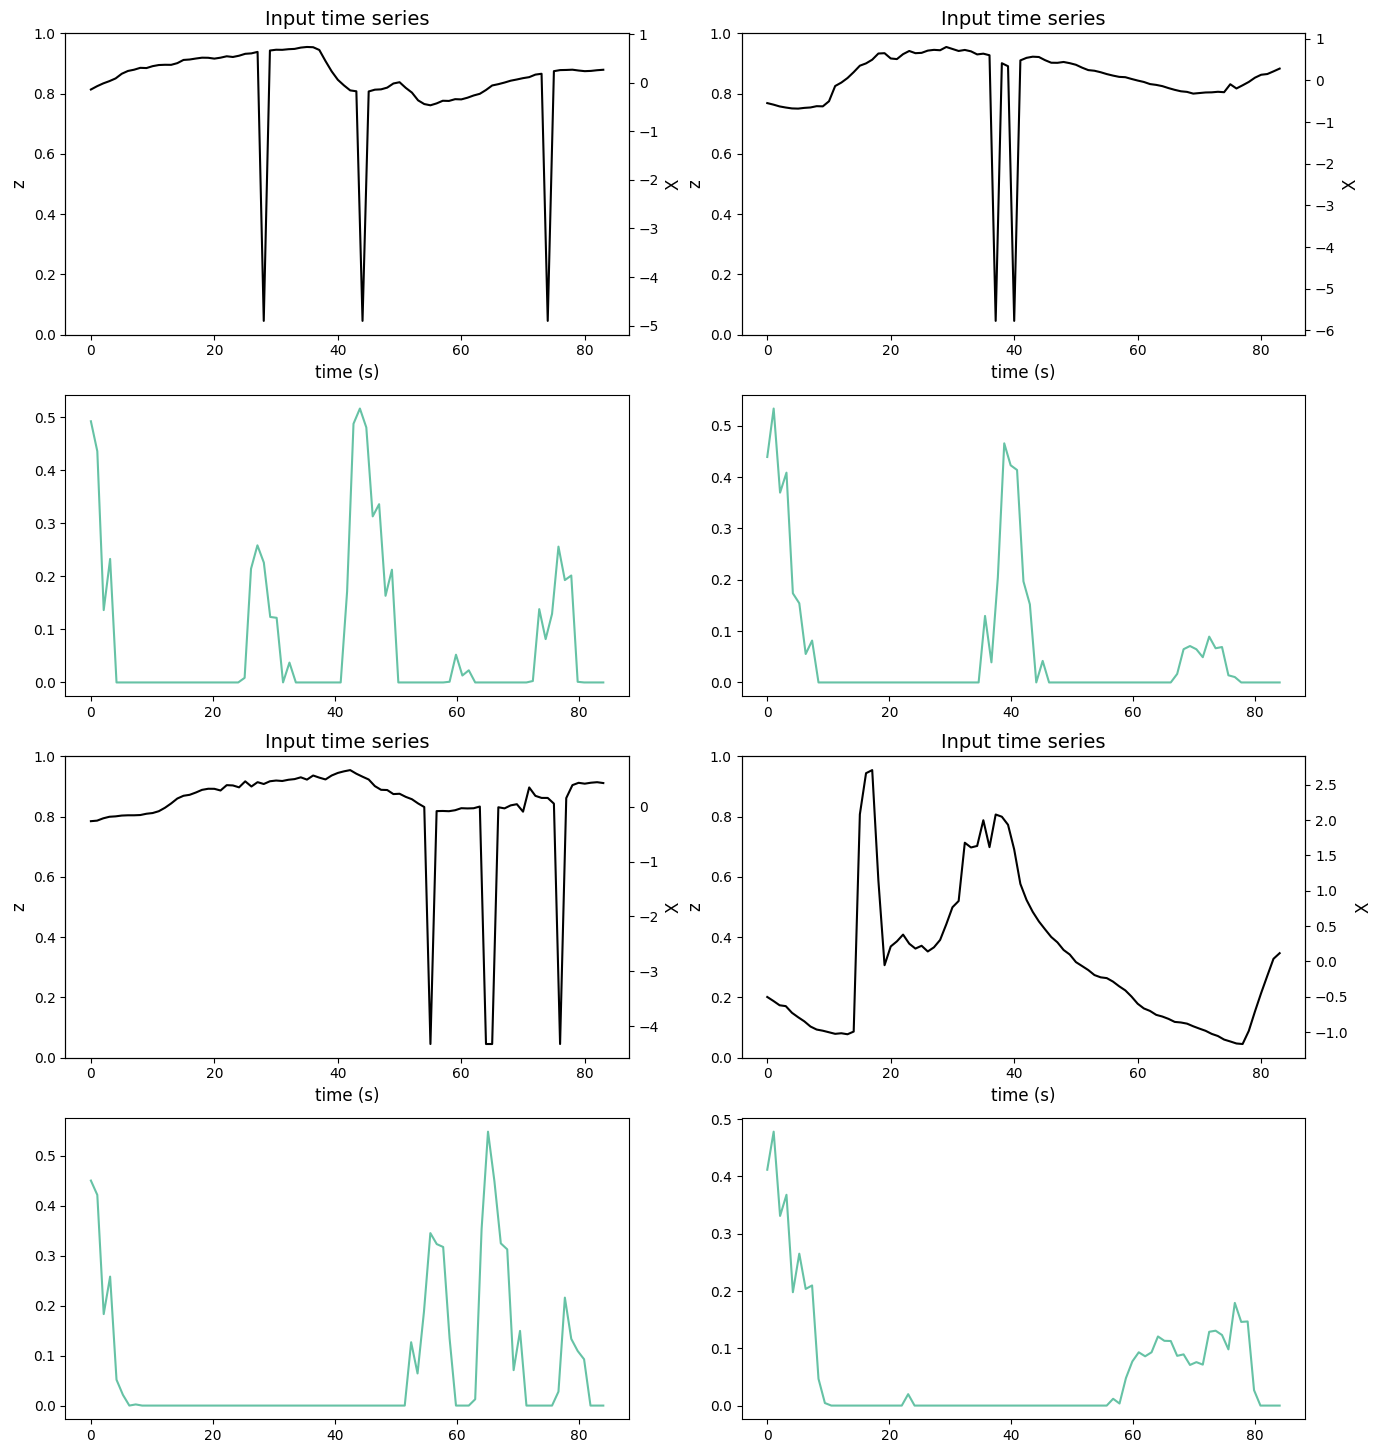

In [11]:
fig, axs = plt.subplots(4, 2, figsize=(16, 18))
line_colors = ["#66c2a5", "#8da0cb"]
bg_color = "#f7f7f7"
X_size = X[0, 0, :].shape
# plot the positive label subplots
k=0
for i in range(0,4, 2):
    hmap_size = res[pos_indices[k], :][0].shape[0]
    axs[i][0].set_title(f"Input time series", fontsize=14)
    axs[i][0].set_xlabel("time (s)", fontsize=12)
    axs[i][0].set_ylabel("z", fontsize=12)
    axs[i+1][0].plot(np.linspace(0, X_size, hmap_size), res[pos_indices[k], :][0].detach(), color=line_colors[0])
    # axs[i+1][0].plot(np.linspace(0, X_size, hmap_size), res[pos_indices[k], :][1].detach(), color=line_colors[1])
    axs[i][0].tick_params(axis="both", labelsize=10, grid_alpha=0.5)
    axs[i+1][0].tick_params(axis="both", labelsize=10, grid_alpha=0.5)

    ax2 = axs[i][0].twinx()
    ax2.set_ylabel("X", color="black", fontsize=12)
    ax2.plot(X[pos_indices[k], 0, :].detach(), color="black")
    ax2.tick_params(axis="y", labelcolor="black", labelsize=10, grid_alpha=0.5)
 

# plot the negative label subplots
    axs[i][1].set_title(f"Input time series", fontsize=14)
    axs[i][1].set_xlabel("time (s)", fontsize=12)
    axs[i][1].set_ylabel("z", fontsize=12)
    axs[i+1][1].plot(np.linspace(0, X_size, hmap_size), res[neg_indices[k], :][0].detach(), color=line_colors[0])
    # axs[i+1][1].plot(np.linspace(0, X_size, hmap_size), res[neg_indices[k], :][1].detach(), color=line_colors[1])
    axs[i][1].tick_params(axis="both", labelsize=10, grid_alpha=0.5)
    axs[i+1][1].tick_params(axis="both", labelsize=10, grid_alpha=0.5)

    ax2 = axs[i][1].twinx()
    ax2.set_ylabel("X", color="black", fontsize=12)
    ax2.plot(X[neg_indices[k], 0, :].detach(), color="black")
    ax2.tick_params(axis="y", labelcolor="black", labelsize=10, grid_alpha=0.5)
    k=k+1
 
plt.savefig('./AnalysisResults/ReproducingPaperResults/heatmap_example_paper.png')